In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import yaml
import os
import calpgs
import submitit
import matplotlib.pyplot as plt

os.environ["R_HOME"] = "/u/project/pasaniuc/kangchen/software/miniconda3/envs/r/lib/R"

In [2]:
trait_list = np.loadtxt("data/traits.txt", dtype=str)
with open(f"data/meta.yaml", "r") as f:
    metadata = yaml.safe_load(f)

VAR_COLS = metadata["VAR_COLS"]
COVAR_COLS = metadata["COVAR_COLS"]

In [3]:
VAR_COLS

['AGE',
 'SEX',
 'PC1',
 'PC2',
 'log_BMI',
 'ever_smoked',
 'drink_alcohol',
 'glasses',
 'income',
 'DEPRIVATION_INDEX',
 'years_of_edu']

In [4]:
COVAR_COLS

['AGE',
 'SEX',
 'AGE*SEX',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10']

In [5]:
def calibrate(prefix: str, trait: str):
    """Build calibration model

    Parameters
    ----------
    prefix : str
        <prefix>.train.tsv, <prefix>.test.tsv will be loaded
    """

    train_path = prefix + ".train.tsv"
    test_path = prefix + ".test.tsv"

    # train model
    for method in ["mean", "mean+var", "mean+var+interact"]:

        if method == "mean":
            mean_cols = ["PGS"] + COVAR_COLS
            var_cols = []
        elif method == "mean+var":
            # remove BMI for BMI, edu for edu
            mean_cols = ["PGS"] + COVAR_COLS
            var_cols = [col for col in VAR_COLS if col != trait]
        elif method == "mean+var+interact":
            mean_cols = (
                ["PGS"]
                + COVAR_COLS
                + [
                    "PGS*AGE",
                    "PGS*SEX",
                    "PGS*PC1",
                    "PGS*PC2",
                ]
            )
            var_cols = [col for col in VAR_COLS if col != trait]
        else:
            raise NotImplementedError

        out_prefix = prefix + "." + method
        calpgs.estimate_coef(
            df_path=train_path,
            y_col="QPHENO",
            mean_cols=mean_cols,
            var_cols=var_cols,
            target_df_path=test_path,
            out_prefix=out_prefix,
        )

        calpgs.quantify_r2(
            df_path=out_prefix + ".pred.tsv",
            y_col="QPHENO",
            pred_col="pred_mean",
            predstd_col="pred_std",
            test_cols=VAR_COLS,
            out_prefix=out_prefix,
            n_bootstrap=10,
        )

In [6]:
def report_quantile_1sd(q, y, qticks=np.arange(-3, 4)):
    for qtick in qticks:
        idx1 = np.argmin(np.abs(q - qtick + 0.5))
        idx2 = np.argmin(np.abs(q - qtick - 0.5))
        print(f"{qtick}: {y[idx1]:.1f}-{y[idx2]:.1f}")


def report_quantile_at(center, q, y, length):
    idx = np.argmin(np.abs(y - center))
    ycenter = y[idx]
    qcenter = q[idx]
    q1, q2 = (qcenter - length / 2), (qcenter + length / 2)
    idx1, idx2 = np.argmin(np.abs(q - q1)), np.argmin(np.abs(q - q2))
    print(
        f"For phenotype at {center}, the range with {length} in normalized scale is {y[idx2] - y[idx1]:.1f}"
    )

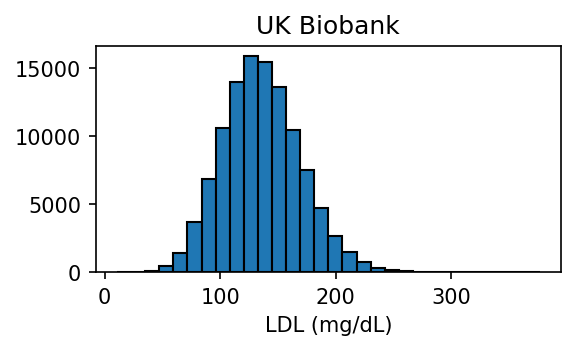

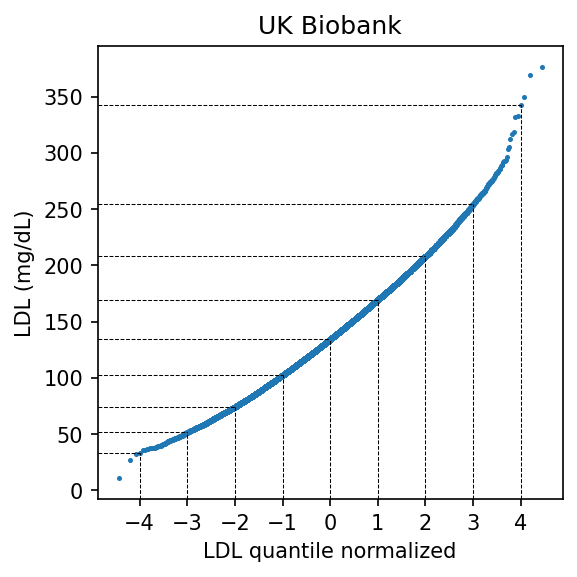

-3: 41.3-62.4
-2: 62.4-87.7
-1: 87.7-118.0
0: 118.0-151.6
1: 151.6-188.1
2: 188.1-229.5
3: 229.5-282.2
For phenotype at 150, the range with 1.33 in normalized scale is 46.6
For phenotype at 150, the range with 1.36 in normalized scale is 47.6
For phenotype at 150, the range with 1.68 in normalized scale is 58.7
For phenotype at 150, the range with 1.78 in normalized scale is 62.1


In [8]:
trait = "LDL"
group = "all"

df_trait = pd.read_csv(
    os.path.join(f"out/format-data/{trait}.{group}.tsv"), index_col=0, sep="\t"
)
if trait == "LDL":
    # mmol/L to mg/dL
    df_trait["PHENO"] *= 38.66976


def plot_quantile(q, y, xticks=np.arange(-4, 5)):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.scatter(q, y, s=2)
    ax.set_xlabel("Quantile normalized)")
    ax.set_ylabel("Raw")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    for xtick in xticks:
        idx = np.argmin(np.abs(q - xtick))
        ytick = y[idx]
        ax.vlines(x=xtick, ymin=ylim[0], ymax=ytick, ls="--", color="black", lw=0.5)
        ax.hlines(y=ytick, xmin=xlim[0], xmax=xtick, ls="--", color="black", lw=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    return fig, ax


fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
ax.hist(df_trait["PHENO"].values, bins=30, edgecolor="black")
ax.set_xlabel("LDL (mg/dL)")
# ax.set_xticks(np.arange(0, 501, 50))
ax.set_title("UK Biobank")
plt.show()

fig, ax = plot_quantile(q=df_trait["QPHENO"].values, y=df_trait["PHENO"].values)
ax.set_xlabel("LDL quantile normalized")
ax.set_ylabel("LDL (mg/dL)")
# ax.set_yticks(np.arange(0, 501, 50))
ax.set_title("UK Biobank")
plt.show()

report_quantile_1sd(q=df_trait["QPHENO"].values, y=df_trait["PHENO"].values)

for length in [1.33, 1.36, 1.68, 1.78]:
    report_quantile_at(
        center=150,
        q=df_trait["QPHENO"].values,
        y=df_trait["PHENO"].values,
        length=length,
    )

In [9]:
out_prefix = "./tmp"
df_trait.to_csv(out_prefix + ".train.tsv", sep="\t")
df_trait.to_csv(out_prefix + ".test.tsv", sep="\t")
calibrate(prefix=out_prefix, trait=trait)

df_params = pd.read_csv(f"{out_prefix}.mean+var.params.tsv", sep="\t", index_col=0)
df_pred = pd.read_csv(f"{out_prefix}.mean+var.pred.tsv", sep="\t", index_col=0)

df_pred["AGE_q"] = pd.qcut(df_pred["AGE"], q=5).cat.codes
df_pred["PC1_q"] = pd.qcut(df_pred["PC1"], q=5).cat.codes
df_pred.groupby(["AGE_q", "PC1_q"]).apply(lambda x: np.mean(x["pred_std"] * 1.65))

AGE_q  PC1_q
0      0        1.339076
       1        1.335386
       2        1.335140
       3        1.358341
       4        1.454436
1      0        1.419943
       1        1.420705
       2        1.417511
       3        1.436047
       4        1.536458
2      0        1.504321
       1        1.503315
       2        1.502509
       3        1.516985
       4        1.612191
3      0        1.591919
       1        1.590012
       2        1.590803
       3        1.598526
       4        1.696376
4      0        1.674495
       1        1.674333
       2        1.670733
       3        1.683834
       4        1.780123
dtype: float64

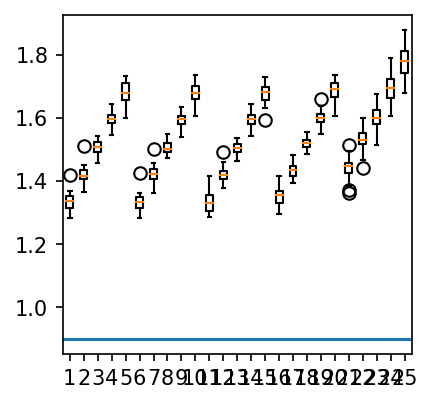

In [10]:
out_dir = "out/calibrate/LDL.all"

df_plot = []

for seed in range(1, 31):
    df = pd.read_csv(f"{out_dir}/{seed}.mean+var.pred.tsv", sep="\t", index_col=0)
    df["AGE_q"] = pd.qcut(df["AGE"], q=5).cat.codes
    df["PC1_q"] = pd.qcut(df["PC1"], q=5).cat.codes
    df_plot.append(
        df.groupby(["PC1_q", "AGE_q"]).apply(lambda x: np.mean(x["pred_std"]) * 1.65)
    )
df_plot = pd.concat(df_plot, axis=1)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.boxplot(df_plot.values.T)
ax.axhline(y=0.9)
fig.show()
df_plot.to_csv("UKB_LDL_ALL.AGE_PC1.tsv", sep="\t")

In [10]:
def run(
    trait: str,
    group: str,
):
    """
    split training and testing data

    Parameters
    ----------
    trait: str
        trait name
    indiv_group: str
        (1) white: white British individuals
        (2) other individuals
    out_prefix: str
        output prefix
    seed: int
        random seed
    """

    df_trait = pd.read_csv(
        os.path.join(f"out/format-data/{trait}.{group}.tsv"), index_col=0, sep="\t"
    )
    if trait == "LDL":
        # mmol/L to mg/dL
        df_trait["PHENO"] *= 38.66976

    out_dir = f"out/calibrate/{trait}.{group}"
    os.makedirs(out_dir, exist_ok=True)

    for seed in range(1, 31):
        out_prefix = f"{out_dir}/{seed}"
        ## split train and test
        df_train, df_test = train_test_split(
            df_trait, train_size=5000, test_size=5000, random_state=seed
        )
        out_dir = os.path.dirname(out_prefix)
        os.makedirs(out_dir, exist_ok=True)
        df_train.to_csv(out_prefix + ".train.tsv", sep="\t")
        df_test.to_csv(out_prefix + ".test.tsv", sep="\t")
        calibrate(prefix=out_prefix, trait=trait)

In [11]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=30,
    memory_g=12,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
        "export R_HOME=/u/project/pasaniuc/kangchen/software/miniconda3/envs/r/lib/R",
    ],
)
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(["LDL", "height", "log_BMI"], ["white", "all"])
    ],
    columns=["trait", "group"],
)

In [12]:
jobs = executor.map_array(
    run,
    df_params.trait,
    df_params.group,
)